From the dataset we observe a few things:
- This is a multilabel image classification problem
    - one or two possible types per image, so not multiclass
- We could make this multiclass if we consider combination types as their own class
    - not sure tho
- there is a class imbalance, far more normal and water types. And ice types are a fifth the size of the largest class
- This [guide](https://www.analyticsvidhya.com/blog/2019/04/build-first-multi-label-image-classification-model-python/) will help

Notes:
- one model for each type, which will give a probablity score for each class
- the top two classes for each image will be the predicted types
    - the second type will have to be above a certain threshold else one type is predicted
    - Our class probabilities are independent of each other

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
%matplotlib inline

In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
train = pd.read_csv('image_tagging/train.csv', nrows=10000) # set limit, delete "nrows" to undo
train.drop(['Name'],axis=1,inplace=True)
train.head()

,Key,Type,normal,fire,water,grass,electric,ice,fighting,poison,ground,flying,psychic,bug,rock,ghost,dragon,dark,steel,fairy
0,110.95,"poison, ground",0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
1,155.408,"fire, fairy",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,360.381,"grass, psychic",0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,6.142e,"fire, flying",0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,289.175,"bug, fairy",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [4]:
train.columns

Index(['Key', 'Type', 'normal', 'fire', 'water', 'grass', 'electric', 'ice',
       'fighting', 'poison', 'ground', 'flying', 'psychic', 'bug', 'rock',
       'ghost', 'dragon', 'dark', 'steel', 'fairy'],
      dtype='object')

In [5]:
TRAINING_DATASET = "/blue/rcstudents/smaley/pokegan/customsprites/blk_bg/input"
IMAGE_SIZE = (256,256,3)

train_image = []
for i in tqdm(range(train.shape[0])):
    # we want them to be 256x256 images 
    img = image.load_img(f"{TRAINING_DATASET}/{train.at[i, 'Key']}.png",target_size=IMAGE_SIZE)
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

100%|██████████| 10000/10000 [00:18<00:00, 549.96it/s]


In [6]:
X.shape

(10000, 256, 256, 3)

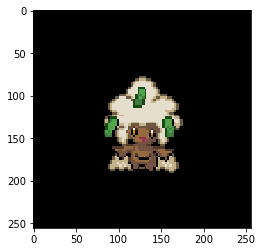

In [7]:
plt.imshow(X[2])

In [8]:
train['Type'][2]

'grass, psychic'

In [9]:
y = np.array(train.drop(['Key', 'Type'],axis=1))
y.shape

(10000, 18)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [11]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=IMAGE_SIZE))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(18, activation='sigmoid')) # make equal to num classes

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 16)      1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 32)      12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 57, 64)        5

In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=64)

Epoch 1/50


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/conv2d/Conv2D (defined at <ipython-input-14-65db1493896e>:1) ]] [Op:__inference_train_function_1455]

Function call stack:
train_function


In [ ]:
model.save('50_epoch.keras')

In [ ]:
import csv

file_path = "image_tagging/all_pokemon_to_type.csv"
pokedex = {}

with open(file_path, mode='r') as file:
    csv_reader = csv.DictReader(file)
    for row in csv_reader:
        key = row['Key']
        value = {col: row[col] for col in row if col != 'Key'}
        pokedex[key] = value

print(pokedex["338.287i"])

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Constants
GRID_SIZE = 8  # 8x8 grid
OUTPUT_FILE = "predictions_grid.png"  # Output file name

# Variables
count = 0
fig, axes = plt.subplots(GRID_SIZE, GRID_SIZE, figsize=(12, 12))
axes = axes.flatten()

# Iterate through the dataset
for idx, file_name in enumerate(os.listdir(TRAINING_DATASET)):
    if count >= GRID_SIZE * GRID_SIZE:  # Limit to 64 images
        break
    
    # Load and preprocess the image
    img_path = os.path.join(TRAINING_DATASET, file_name)
    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img) / 255.0  # Normalize
    classes = np.array(train.columns[2:])
    
    # Make predictions
    proba = model.predict(img_array.reshape(1,256,256,3))
    top_2 = np.argsort(proba[0])[:-3:-1]  # Get top 2 predictions
    top_2_predictions = [f"{classes[i]} ({proba[0][i]:.2f})" for i in top_2]
    
    # Get ground truth
    ground_truth = pokedex[file_name[:-4]]["Type"]
    
    # Plot image in grid
    axes[idx].imshow(img)
    axes[idx].axis('off')  # Turn off axis
    axes[idx].set_title(f"P: {', '.join(top_2_predictions)}\nA: {ground_truth}", fontsize=6)
    
    count += 1

# Adjust layout and save the grid
plt.tight_layout()
plt.savefig(OUTPUT_FILE, dpi=300)
plt.show()